<a href="https://colab.research.google.com/github/kevwee-lab/GA-Capstone-Food-Classifier/blob/main/Capstone_EDA__TransferLearning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Currently, unmanned supermarkets/ convenience stores are gaining traction in China.
Given the current pandemic situation, such a business model is ideal, as it minimizes human contact, and reduces queues. <br>

**Can we create a food classifier to facilitate self check outs, so as to help retail and fnb businesses save on manpower and productivity costs?**

## Executive Summary

For this project, we will be using the food 101 dataset from Kaggle to build a classifier for food. The food 101 dataset comprises 101 categories of food ranging from apple pies to waffles, and each category has 1000 images. From this dataset, we will first be using 5 categories of food to create a 5 class Japanese Food classifier to experiment with fitting it to pretrained models like VGG16. Subsequently for our actual modelling, we will be using another 10 categories of food that are similar to each other, e.g. cake/dessert to train our models with.

We will also be building our own convolutional neural network and test its performance against a few pre-trained networks like  EfficientNet and VGG16. We will evaluate each model using accuracy as the main metric, finetune and re-evaluate the models before deciding on the best model for production. 

Finally, we will evaluate how well our best model can classify unseen data.

In [ ]:
import os
import random
import numpy as np
import cv2
import h5py
import json
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model,load_model,Sequential
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#installing kaggle as we will be downloading dataset directly into our gdrive
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
from google.colab import files
files.upload() 

In [ ]:
#Download required dataset / competition files to a folder of your choice
!kaggle datasets download -d kmader/food41 -p /content/gdrive/MyDrive/capstone_project/datasets

100% 5.30G/5.30G [01:29<00:00, 55.6MB/s]
100% 5.30G/5.30G [01:29<00:00, 63.4MB/s]


In [ ]:
#change working directory
os.chdir('/content/gdrive/MyDrive/capstone_project/datasets/')


In [ ]:
#unzip the downloaded dataset, and remove the zip file after 
!unzip \*.zip  && rm *.zip 

## Exploring the dataset

We will explore the dataset as other than image files, there are also files in the dataset that come in text, json aand hdf5 format 

### Exploring the meta folder

In [ ]:
#exploring the meta folder
!ls /content/gdrive/MyDrive/capstone_project/datasets/meta/meta

classes.txt  labels.txt  test.json  test.txt  train.json  train.txt


In [ ]:
# exploring the json files
with open('meta/meta/test.json') as json_file:
    test_json = json.load(json_file)

test_json['apple_pie']

['apple_pie/1011328',
 'apple_pie/101251',
 'apple_pie/1034399',
 'apple_pie/103801',
 'apple_pie/1038694',
 'apple_pie/1047447',
 'apple_pie/1068632',
 'apple_pie/110043',
 'apple_pie/1106961',
 'apple_pie/1113017',
 'apple_pie/116705',
 'apple_pie/1167170',
 'apple_pie/1174330',
 'apple_pie/1180600',
 'apple_pie/1235282',
 'apple_pie/1269202',
 'apple_pie/1272958',
 'apple_pie/1284428',
 'apple_pie/1295996',
 'apple_pie/129668',
 'apple_pie/1321400',
 'apple_pie/1327259',
 'apple_pie/1332030',
 'apple_pie/1364847',
 'apple_pie/1375404',
 'apple_pie/1398774',
 'apple_pie/1420999',
 'apple_pie/1429866',
 'apple_pie/1444702',
 'apple_pie/1461580',
 'apple_pie/1469191',
 'apple_pie/1472631',
 'apple_pie/1510125',
 'apple_pie/1510930',
 'apple_pie/1514110',
 'apple_pie/1526484',
 'apple_pie/1578710',
 'apple_pie/1579622',
 'apple_pie/1579774',
 'apple_pie/1617515',
 'apple_pie/1617793',
 'apple_pie/1626685',
 'apple_pie/1629072',
 'apple_pie/1657587',
 'apple_pie/1674492',
 'apple_pie/168

In [ ]:
# exploring the json files
with open('meta/meta/train.json') as json_file:
    train_json = json.load(json_file)

train_json['apple_pie']

['apple_pie/1005649',
 'apple_pie/1014775',
 'apple_pie/1026328',
 'apple_pie/1028787',
 'apple_pie/1043283',
 'apple_pie/1050519',
 'apple_pie/1057749',
 'apple_pie/1057810',
 'apple_pie/1072416',
 'apple_pie/1074856',
 'apple_pie/1074942',
 'apple_pie/1076891',
 'apple_pie/1077610',
 'apple_pie/1077964',
 'apple_pie/1088809',
 'apple_pie/1097378',
 'apple_pie/1103795',
 'apple_pie/1109597',
 'apple_pie/1111062',
 'apple_pie/1112300',
 'apple_pie/1112838',
 'apple_pie/1121884',
 'apple_pie/112378',
 'apple_pie/1133267',
 'apple_pie/1142597',
 'apple_pie/1147371',
 'apple_pie/1154371',
 'apple_pie/1158360',
 'apple_pie/1159801',
 'apple_pie/1165004',
 'apple_pie/1166116',
 'apple_pie/1166210',
 'apple_pie/116697',
 'apple_pie/1174241',
 'apple_pie/1174949',
 'apple_pie/1177254',
 'apple_pie/118237',
 'apple_pie/1184568',
 'apple_pie/1185445',
 'apple_pie/1185654',
 'apple_pie/1191665',
 'apple_pie/1196628',
 'apple_pie/1199851',
 'apple_pie/1200079',
 'apple_pie/1214326',
 'apple_pie/1

In [ ]:
len(train_json['apple_pie'])

750

In [ ]:
len(test_json['apple_pie'])

250

In [ ]:
#exploring train txt file
with open('meta/meta/train.txt', 'r') as f:
    train_text = f.read()

train_text

'apple_pie/1005649\napple_pie/1014775\napple_pie/1026328\napple_pie/1028787\napple_pie/1043283\napple_pie/1050519\napple_pie/1057749\napple_pie/1057810\napple_pie/1072416\napple_pie/1074856\napple_pie/1074942\napple_pie/1076891\napple_pie/1077610\napple_pie/1077964\napple_pie/1088809\napple_pie/1097378\napple_pie/1103795\napple_pie/1109597\napple_pie/1111062\napple_pie/1112300\napple_pie/1112838\napple_pie/1121884\napple_pie/112378\napple_pie/1133267\napple_pie/1142597\napple_pie/1147371\napple_pie/1154371\napple_pie/1158360\napple_pie/1159801\napple_pie/1165004\napple_pie/1166116\napple_pie/1166210\napple_pie/116697\napple_pie/1174241\napple_pie/1174949\napple_pie/1177254\napple_pie/118237\napple_pie/1184568\napple_pie/1185445\napple_pie/1185654\napple_pie/1191665\napple_pie/1196628\napple_pie/1199851\napple_pie/1200079\napple_pie/1214326\napple_pie/1215650\napple_pie/1218767\napple_pie/1220194\napple_pie/1230465\napple_pie/1232311\napple_pie/123782\napple_pie/1239205\napple_pie/12405

In [ ]:
#exploring test txt file
with open('meta/meta/test.txt', 'r') as f:
    test_text = f.read()

test_text

'apple_pie/1011328\napple_pie/101251\napple_pie/1034399\napple_pie/103801\napple_pie/1038694\napple_pie/1047447\napple_pie/1068632\napple_pie/110043\napple_pie/1106961\napple_pie/1113017\napple_pie/116705\napple_pie/1167170\napple_pie/1174330\napple_pie/1180600\napple_pie/1235282\napple_pie/1269202\napple_pie/1272958\napple_pie/1284428\napple_pie/1295996\napple_pie/129668\napple_pie/1321400\napple_pie/1327259\napple_pie/1332030\napple_pie/1364847\napple_pie/1375404\napple_pie/1398774\napple_pie/1420999\napple_pie/1429866\napple_pie/1444702\napple_pie/1461580\napple_pie/1469191\napple_pie/1472631\napple_pie/1510125\napple_pie/1510930\napple_pie/1514110\napple_pie/1526484\napple_pie/1578710\napple_pie/1579622\napple_pie/1579774\napple_pie/1617515\napple_pie/1617793\napple_pie/1626685\napple_pie/1629072\napple_pie/1657587\napple_pie/1674492\napple_pie/168971\napple_pie/175848\napple_pie/1771374\napple_pie/1773419\napple_pie/1774036\napple_pie/1815947\napple_pie/1847621\napple_pie/1854241\

In [ ]:
#exploring classes txt file
with open('meta/meta/classes.txt', 'r') as f:
    classes_text = f.read()

classes_text

'apple_pie\nbaby_back_ribs\nbaklava\nbeef_carpaccio\nbeef_tartare\nbeet_salad\nbeignets\nbibimbap\nbread_pudding\nbreakfast_burrito\nbruschetta\ncaesar_salad\ncannoli\ncaprese_salad\ncarrot_cake\nceviche\ncheesecake\ncheese_plate\nchicken_curry\nchicken_quesadilla\nchicken_wings\nchocolate_cake\nchocolate_mousse\nchurros\nclam_chowder\nclub_sandwich\ncrab_cakes\ncreme_brulee\ncroque_madame\ncup_cakes\ndeviled_eggs\ndonuts\ndumplings\nedamame\neggs_benedict\nescargots\nfalafel\nfilet_mignon\nfish_and_chips\nfoie_gras\nfrench_fries\nfrench_onion_soup\nfrench_toast\nfried_calamari\nfried_rice\nfrozen_yogurt\ngarlic_bread\ngnocchi\ngreek_salad\ngrilled_cheese_sandwich\ngrilled_salmon\nguacamole\ngyoza\nhamburger\nhot_and_sour_soup\nhot_dog\nhuevos_rancheros\nhummus\nice_cream\nlasagna\nlobster_bisque\nlobster_roll_sandwich\nmacaroni_and_cheese\nmacarons\nmiso_soup\nmussels\nnachos\nomelette\nonion_rings\noysters\npad_thai\npaella\npancakes\npanna_cotta\npeking_duck\npho\npizza\npork_chop\n

The train and test json files comprise 750 images and 250 images of each category of food with its associated image filename separated by a '/'. This means that the train and test sets have already been defined for us using a 75%, 25% split. 

The train and test text files are similar to the json files. The classes text file provides us with the different categories/classes of the food.



### Exploring the h5 format files

A h5 format file, or a HDF5 (hierachical data format) file is a container for two kinds of objects: datasets, which are array-like collections of data, and groups, which are folder-like containers that hold datasets and other groups. We will explore 2 h5 format files to get a sense of what is within these files.

In [ ]:
f = h5py.File('food_c101_n10099_r64x64x3.h5', 'r')

In [ ]:
print(list(f.keys()))

['category', 'category_names', 'images']


In [ ]:
print(list(f.values()))

[<HDF5 dataset "category": shape (10099, 101), type "|b1">, <HDF5 dataset "category_names": shape (101,), type "|S40">, <HDF5 dataset "images": shape (10099, 64, 64, 3), type "|u1">]


In [ ]:
#exploring the key'category' and its datatype 
category_data = f['category']
category_data.shape

(10099, 101)

In [ ]:
category_data.dtype

dtype('bool')

In [ ]:
#exploring the key'category_names' and its datatype 
category_names = f['category_names']
category_names.shape

(101,)

In [ ]:
category_names.dtype

dtype('S40')

In [ ]:
#exploring the key'category_names' and its datatype 
image_data = f['images']
image_data.shape

(10099, 64, 64, 3)

In [ ]:
image_data.dtype

dtype('uint8')

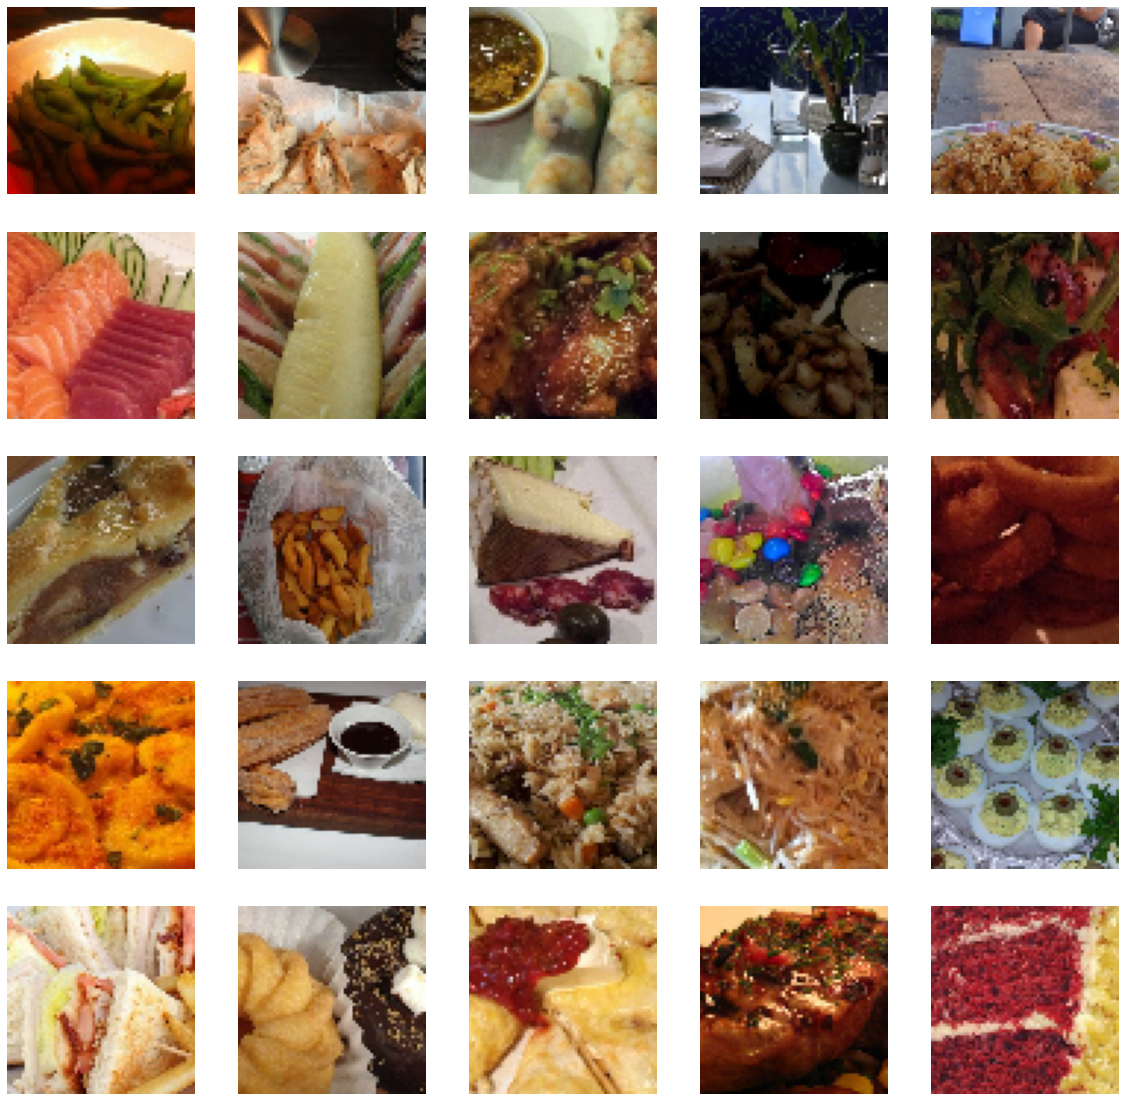

In [ ]:
fig = plt.figure(figsize=(20,20))
n = 25
col = 5
for i in range(n):
    ax=fig.add_subplot(n / col, col, i + 1)
    ax.imshow(image_data[i])
    ax.axis('off')

The food_c101_n10099_r64x64x3.h5 file comprises 3 datasets. The first, 'category' comprises 10099 rows and 101 columns with the boolean datatype. The second dataset, 'category_names' comprises 101 rows of data with the structured datatype (presumably strings) and 'images' comprises 10099 RGB images with 64 x 64 dimensions. 

In [ ]:
#exploring another h5 format file
f1 = h5py.File('food_c101_n10099_r64x64x1.h5', 'r')

In [ ]:
print(list(f1.keys()))

['category', 'category_names', 'images']


In [ ]:
print(list(f1.values()))

[<HDF5 dataset "category": shape (10099, 101), type "|b1">, <HDF5 dataset "category_names": shape (101,), type "|S40">, <HDF5 dataset "images": shape (10099, 64, 64, 1), type "<f8">]


In [ ]:
#exploring the key'category' and its datatype 
category_data_1 = f1['category']
category_data_1.shape

(10099, 101)

In [ ]:
category_data_1.dtype

dtype('bool')

In [ ]:
#exploring the key'category_names' and its datatype 
category_names_1 = f1['category_names']
category_names_1.shape

(101,)

In [ ]:
category_names_1.dtype

dtype('S40')

In [ ]:
#exploring the key'images' and its datatype 
image_data_1 = f1['images']
image_data_1.shape

(10099, 64, 64, 1)

In [ ]:
image_data_1.dtype

dtype('<f8')

Similar to the earlier h5 file we explored, we see that the food_c101_n10099_r64x64x1.h5 also comprises similar dataset keys and values. The only exception is that the images are in a greyscale format instead of RGB, and there are more images and more rows in categories (10099). We also see a strange datatype "<f8". After some online research, we know that f8 data type refers to 64 bit floating point numbers and the < sign refers to little endian, which is related to storage. Little endian is when the least significant bytes are stored before the more significant bytes. 

### Exploring image folder

In [ ]:
!ls /content/gdrive/MyDrive/capstone_project/datasets/images

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheesecake	    grilled_salmon	     risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

In [ ]:
food_cat_list = os.listdir('/content/gdrive/MyDrive/capstone_project/datasets/images')

In [ ]:
len(food_cat_list)

101

There are 101 food categories in our image folder.

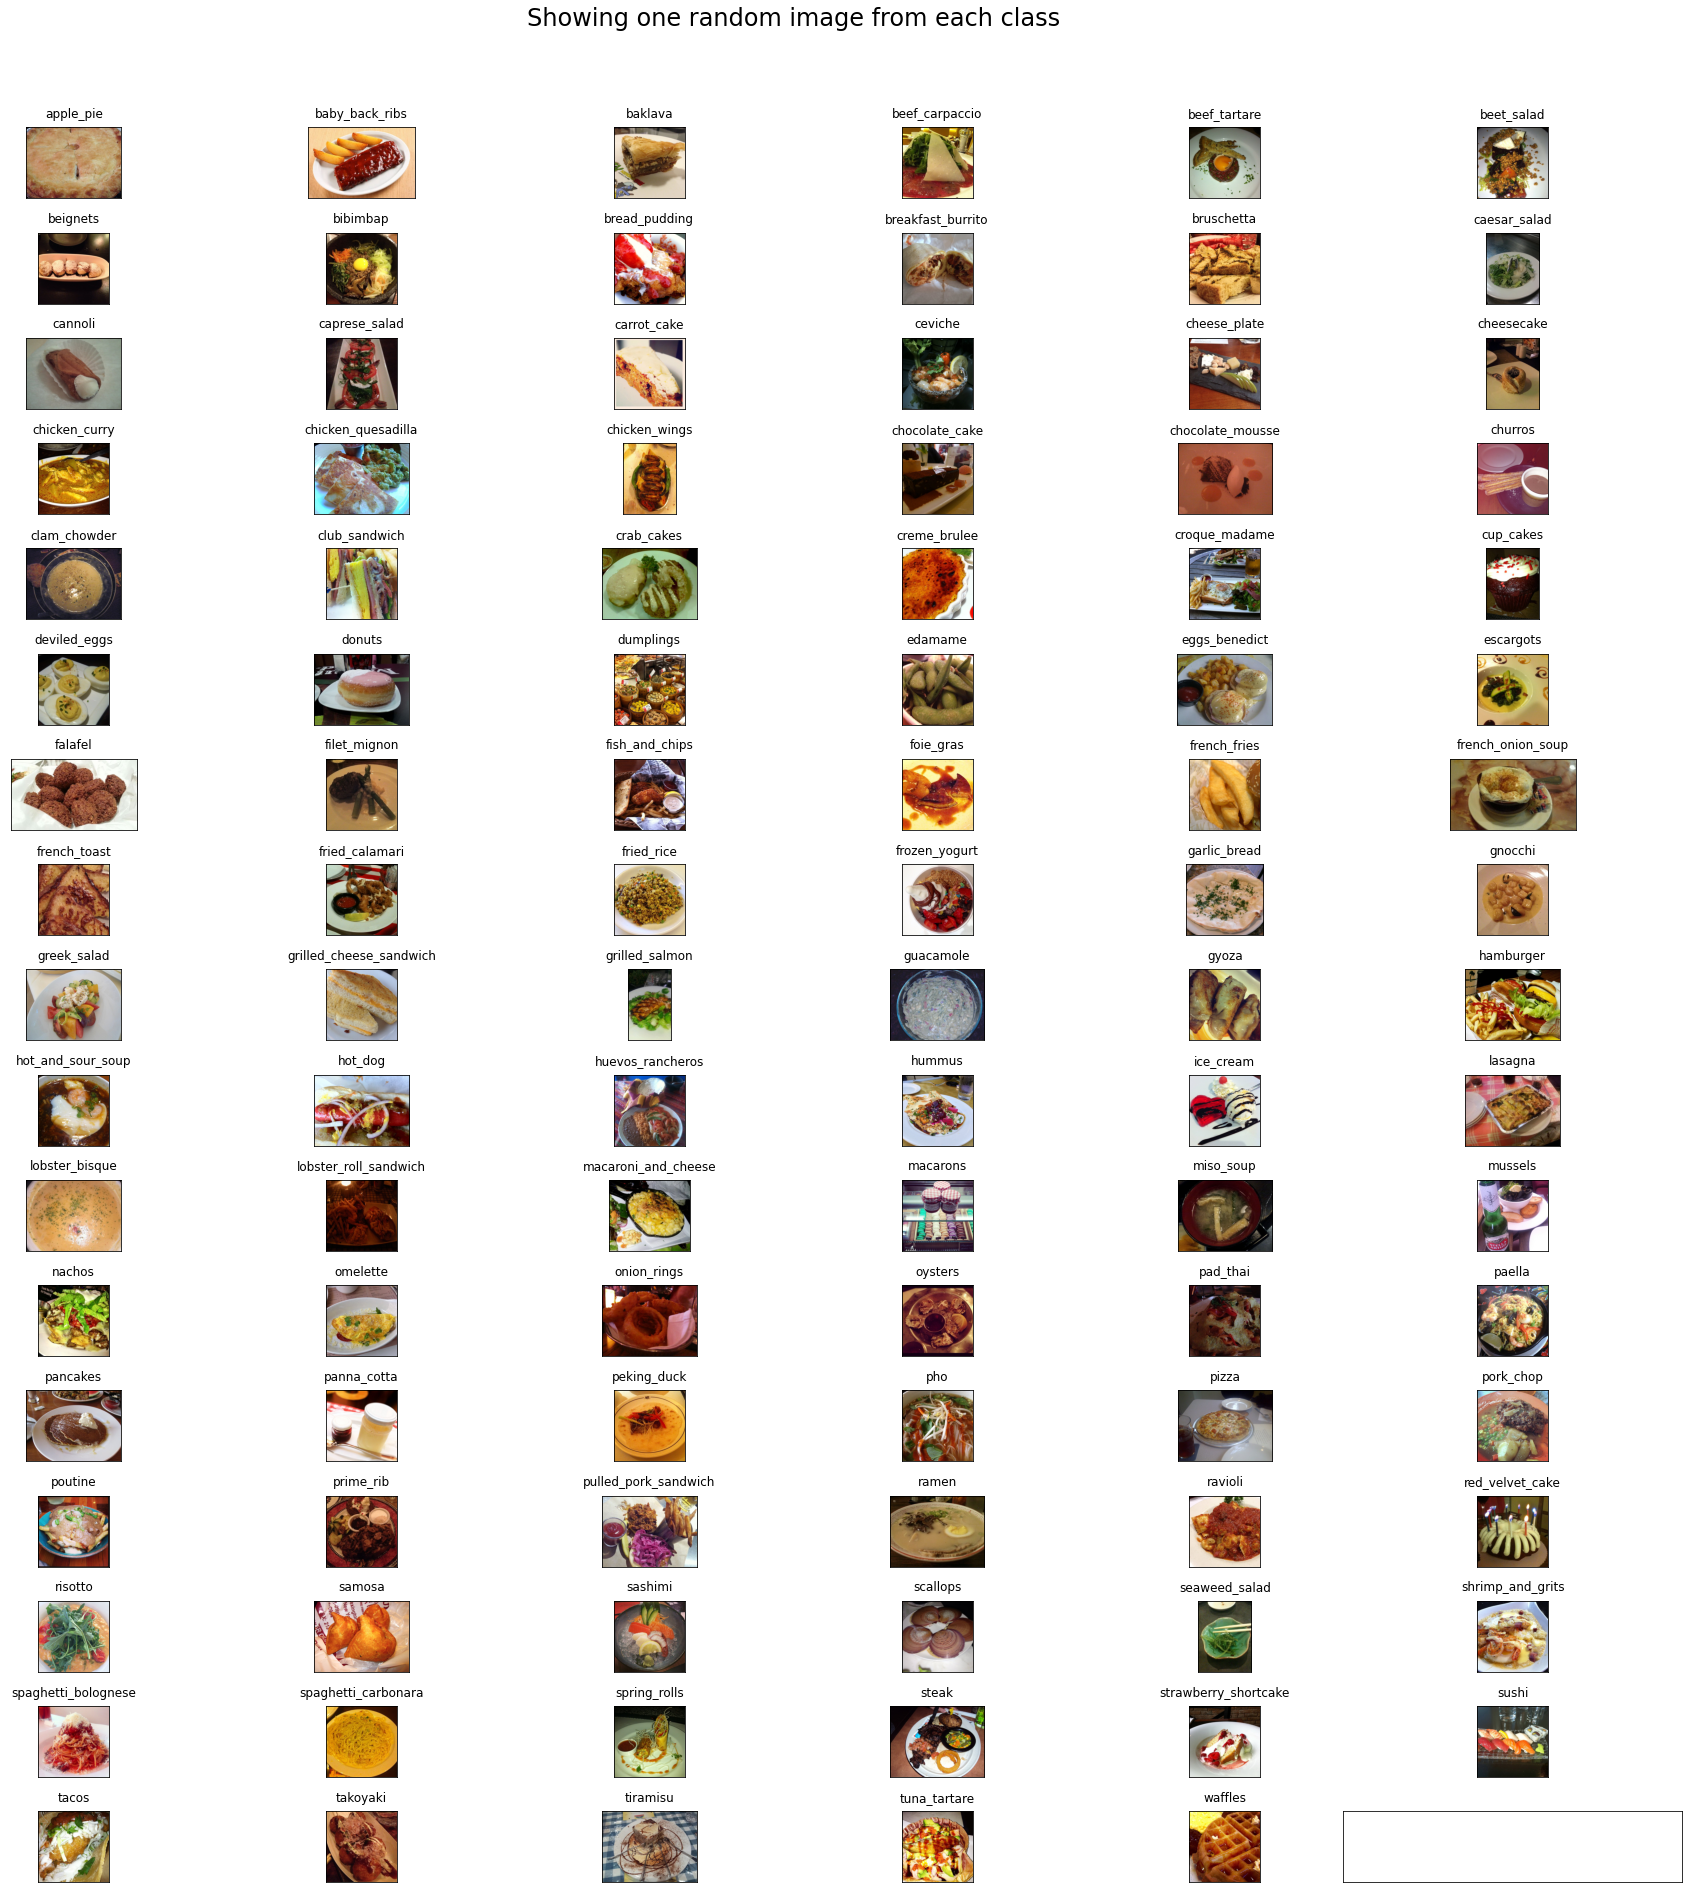

In [ ]:
#visualizing images in image folder 
# random selection of 1 image from each category/folder in images

rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) 
data_dir = '/content/gdrive/MyDrive/capstone_project/datasets/images'
foods_sorted = sorted(food_cat_list)
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
     # returns the list of all files present in each food category
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) 
     # picks one food item from the list as choice, takes a list and returns one random item
    food_selected_random = np.random.choice(food_selected_images)
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

Based on the visualisation, the food category names and the images match each other, implying that data in the image folders seem to be in order.

## Train-Test-Split and Preprocessing

Now that we have done our basic dataset exploration, we will proceed to build our own CNN, and also fit our dataset with pretrained models.

Before we do this, we will first narrow our categories down to 5 classes (japanese food) to try fitting the different models.

We will also perform a train test split for the images and preprocess the images and categories.

In [ ]:
#create dataframe for all food images with their category names
from glob import glob
import pandas as pd

image_dir = '/content/gdrive/MyDrive/capstone_project/datasets/images'
#use glob to grab all the image paths 
food_images = glob(os.path.join(image_dir, '*', '*')) 
#create a dataframe with the paths of the images
food_df = pd.DataFrame(dict(path = food_images)) 
#create category by separating the food name from path and replacing '_' with ''
food_df['category'] = food_df['path'].map(lambda x: x.split('/')[-2].replace('_', ' ')) 

food_df.head()

path category
0  /content/gdrive/MyDrive/capstone_project/datas...  edamame
1  /content/gdrive/MyDrive/capstone_project/datas...  edamame
2  /content/gdrive/MyDrive/capstone_project/datas...  edamame
3  /content/gdrive/MyDrive/capstone_project/datas...  edamame
4  /content/gdrive/MyDrive/capstone_project/datas...  edamame

In [ ]:
#saving food dataframe into csv
food_df.to_csv('food_df.csv', index=False)

In [ ]:
# creating a japanese food df with 5 classes
jap_edamame = food_df[food_df['category'] == 'edamame']
jap_ramen = food_df[food_df['category'] == 'ramen']
jap_sushi = food_df[food_df['category'] == 'sushi']
jap_sashimi = food_df[food_df['category'] == 'sashimi']
jap_miso = food_df[food_df['category'] == 'miso soup']

In [ ]:
# Add Class columns - edamame 0, ramen 1, sushi 2, sashimi 3, miso 4
jap_edamame['class'] = pd.Series([0 for x in range(len(jap_edamame.index))], index=jap_edamame.index)
jap_ramen['class'] = pd.Series([1 for x in range(len(jap_ramen.index))], index=jap_ramen.index)
jap_sushi['class'] = pd.Series([2 for x in range(len(jap_sushi.index))], index=jap_sushi.index)
jap_sashimi['class'] = pd.Series([3 for x in range(len(jap_sashimi.index))], index=jap_sashimi.index)
jap_miso['class'] = pd.Series([4 for x in range(len(jap_miso.index))], index=jap_miso.index)


In [ ]:

# Split into train and validation sets
train_set_percentage = 0.8


train_df = jap_edamame[:int(len(jap_edamame)*train_set_percentage)]
val_df = jap_edamame[int(len(jap_edamame)*train_set_percentage):]

train_df2 = jap_ramen[:int(len(jap_ramen)*train_set_percentage)]
val_df2 = jap_ramen[int(len(jap_ramen)*train_set_percentage):]

train_df3 = jap_sushi[:int(len(jap_sushi)*train_set_percentage)]
val_df3 = jap_sushi[int(len(jap_sushi)*train_set_percentage):]

train_df4 = jap_sashimi[:int(len(jap_sashimi)*train_set_percentage)]
val_df4 = jap_sashimi[int(len(jap_sashimi)*train_set_percentage):]

train_df5 = jap_miso[:int(len(jap_miso)*train_set_percentage)]
val_df5 = jap_miso[int(len(jap_miso)*train_set_percentage):]


#concatenate the dataframes 
df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, train_df5])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5])

df_new_train = df_new_train.drop(columns='category')
df_new_val = df_new_val.drop(columns='category')


#shuffle
df_train = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [ ]:
# Explore the train test set
df_train.head()

path  class
0  /content/gdrive/MyDrive/capstone_project/datas...      4
1  /content/gdrive/MyDrive/capstone_project/datas...      2
2  /content/gdrive/MyDrive/capstone_project/datas...      0
3  /content/gdrive/MyDrive/capstone_project/datas...      1
4  /content/gdrive/MyDrive/capstone_project/datas...      3

In [ ]:
df_train.shape

(4000, 2)

In [ ]:
df_train['class'].unique()

array([4, 2, 0, 1, 3])

In [ ]:
df_val.shape

(1000, 2)

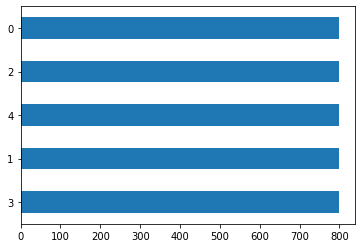

In [ ]:
#visualising the 5 classes to see if there is any imbalance
df_train['class'].value_counts().plot(kind='barh')

There does not seem to be any imbalance in the classes.

In [ ]:
#saving train test dataframes into csv
df_train.to_csv('train.csv')
df_val.to_csv('test.csv')

### Creating Data Preprocessing and Resizing Pipeline

Now we will need to do some preprocessing to our images, as they will need to be resized before transfer learning to fit the model's requirements.





In [ ]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df_train['path'].tolist()
train_labels_list = df_train['class'].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val['path'].tolist()
val_labels_list = df_val['class'].astype('int32').tolist()

#number of classes
num_classes = 5

In [ ]:
# Set up some Hyperparameters
batch_size = 32
lr = 0.001

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
#img_rows, img_cols = 299,299
img_rows, img_cols = 224,224

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
# creating a constant tensor of filenames from list
filenames = tf.constant(train_filenames_list)

# creating a constant tensor of labels from a list
labels = tf.constant(train_labels_list)

# creating constant tensors from validation data lists
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

In [ ]:
# Assembling data pipeline 
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(32)

## Experimenting with transfer learning using subset of data

We will first attempt to fit our data on a pretrained model, VGG16 as our "base model". VGG16 is a convolutional neural network model which has achieved 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 [classes](https://neurohive.io/en/popular-networks/vgg16/). 

### Setting up VGG 16

In [ ]:
# create the base pre-trained model
base_cnn = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224, 224, 3)) #remove the last prediction layer by declaring include_top=False


58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
len(base_cnn.layers)

19

In [ ]:
# adding additional layers to our base model

# add a global spatial average pooling layer
x = base_cnn.output

#Adaptive Pooling
x = GlobalAveragePooling2D()(x) 

x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# we use softmax here because we are predicting multiple classes
predictions = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_cnn.input, outputs=predictions)
len(model.layers)

23

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# train only the top layers 
# freeze all convolutional VGG16 layers. 
#Freezing reduces training time as the backward passes go down in number.

for layer in base_cnn.layers:
    layer.trainable = False

for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d_1
True
dense_2
True
dropout
True
dense_3
True


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Now that we have set our base cnn model up, we will define our optimizer and proceed to compile our model.

In [ ]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr)

# compile the model 
model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
#create model checkpoint to save our model and weights

!mkdir checkpoints

checkpoint = ModelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

### Fit and evaluate the model


In [ ]:
#define the train, val steps and epochs

train_steps = 100
val_steps = 100
epochs = 10

In [ ]:
# Train the model 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Epoch 1/10
100/100 [==============================] - 1093s 10s/step - loss: 2.5245 - acc: 0.6663 - val_loss: 0.6382 - val_acc: 0.8506

Epoch 00001: val_loss improved from inf to 0.63822, saving model to ./checkpoints/weights_01_0.85.hdf5
Epoch 2/10
100/100 [==============================] - 223s 2s/step - loss: 0.6632 - acc: 0.8420 - val_loss: 0.5071 - val_acc: 0.8431

Epoch 00002: val_loss improved from 0.63822 to 0.50712, saving model to ./checkpoints/weights_02_0.84.hdf5
Epoch 3/10
100/100 [==============================] - 42s 426ms/step - loss: 0.4315 - acc: 0.8584 - val_loss: 0.4550 - val_acc: 0.8591

Epoch 00003: val_loss improved from 0.50712 to 0.45500, saving model to ./checkpoints/weights_03_0.86.hdf5
Epoch 4/10
100/100 [==============================] - 43s 430ms/step - loss: 0.2616 - acc: 0.9052 - val_loss: 0.4541 - val_acc: 0.8619

Epoch 00004: val_loss improved from 0.45500 to 0.45415, saving model to ./checkpoints/weights_04_0.86.hdf5
Epoch 5/10
100/100 [==============

It seems like our best epoch with the least validation loss is at epoch 6. We will likely use the weights we saved from epoch 6.

In [ ]:
#checking the weights saved 
!ls checkpoints

weights_01_0.85.hdf5  weights_03_0.86.hdf5  weights_06_0.88.hdf5
weights_02_0.84.hdf5  weights_04_0.86.hdf5


In [ ]:
#evaluating model accuracy
metrics = model.evaluate(valid_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 11s 215ms/step - loss: 0.6096 - acc: 0.8487
model accuracy: 0.8487499952316284


Our base_cnn model seems to be able to perform reasonably well, achieving an 84.8% in accuracy.

In [ ]:
#loading weights from epoch 6
model.load_weights('./checkpoints/weights_06_0.88.hdf5')

### Making predictions

In [ ]:
preds = model.predict(valid_dataset,steps=10)
preds = preds.argmax(axis=-1)

# we take 320 samples for prediction
preds.shape

(320,)

In [ ]:
test_labels = val_labels_list[0:320]

In [ ]:
len(test_labels)

320

In [ ]:
#plotting a confusion matrix to visualise the model predictions

from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral:

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.92307692 0.03076923 0.01538462 0.01538462 0.01538462]
 [0.         0.91525424 0.01694915 0.03389831 0.03389831]
 [0.02816901 0.01408451 0.8028169  0.14084507 0.01408451]
 [0.         0.01694915 0.11864407 0.86440678 0.        ]
 [0.01515152 0.07575758 0.         0.         0.90909091]]


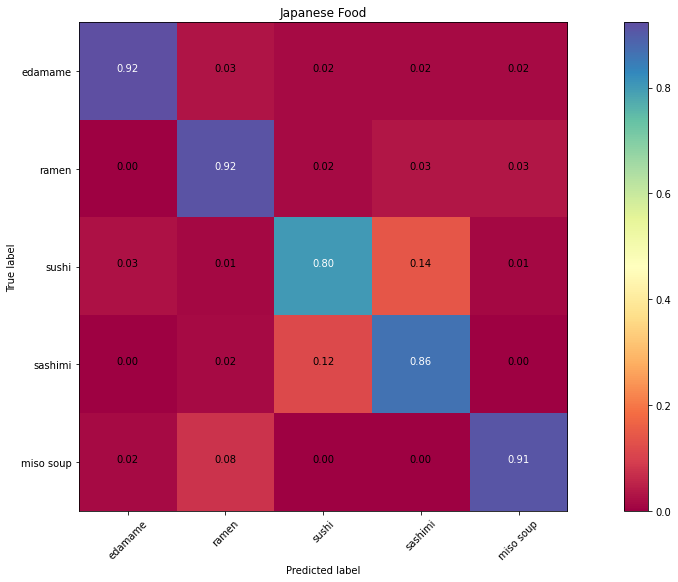

In [ ]:
names = ['edamame', 'ramen', 'sushi', 'sashimi', 'miso soup']
cm_plot_labels = names

# Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Japanese Food')
plt.show()

From the confusion matrix we plotted, it looks like our model can predict the classes of food with reasonable accuracy. It is worth noting that sushi seems to be more frequently misclassified as sashimi and vice versa. Considering that the 2 dishes are largely similar (with the difference being rice), it seems reasonable that the misclassification could happen.

In [ ]:
#saving model and weights

model.save('jap_food_5_classes.h5')
model.save_weights('jap_food_5_classes_weights.h5', save_format='h5')

## Testing if our model can generalise well on unseen data

### Predicting Ramen

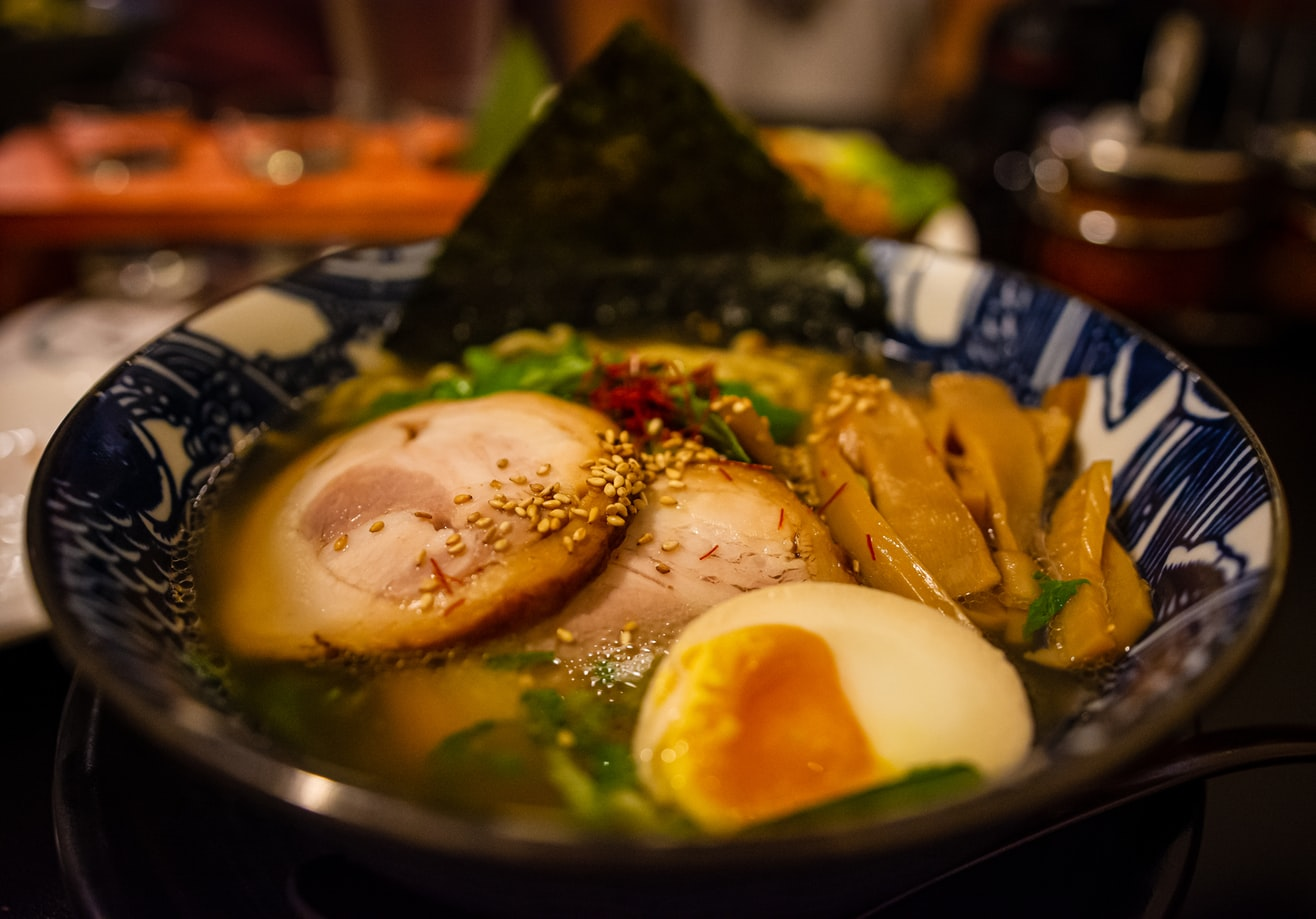

In [ ]:
#downloaded picture from unsplash

from IPython.display import Image

image_name = 'ramen_test.jpg'
Image(image_name)

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = image.load_img(image_name, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[0.02769638 0.766129   0.00975059 0.11803426 0.07838977]]
1


In [ ]:
result= np.argmax(pred)
if result==0:
    print("edamame")
elif result==1:
    print("ramen")
elif result==2:
    print("sushi")
elif result==3:
    print("sashimi")
elif result==4:
    print("miso soup")

ramen


### Predicting sushi

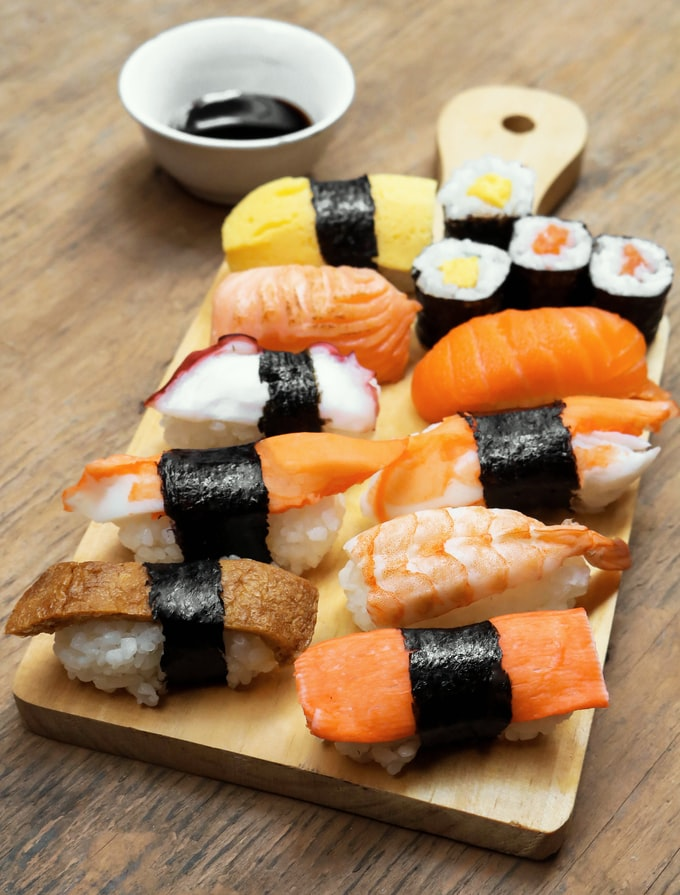

In [ ]:
#downloaded picture from unsplash
image_name2 = 'sushi_test.jpg'
Image(image_name2)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img2 = image.load_img(image_name2, target_size=(224, 224))
x = image.img_to_array(img2)
x = np.expand_dims(x, axis=0) #Insert a new axis that will appear at the axis position in the expanded array shape.
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
pred = model.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[9.5938979e-10 8.8239235e-11 9.9999917e-01 8.1372946e-07 5.5574646e-12]]
2


In [ ]:
result= np.argmax(pred)
if result==0:
    print("edamame")
elif result==1:
    print("ramen")
elif result==2:
    print("sushi")
elif result==3:
    print("sashimi")
elif result==4:
    print("miso soup")

sushi


### Predicting edamame

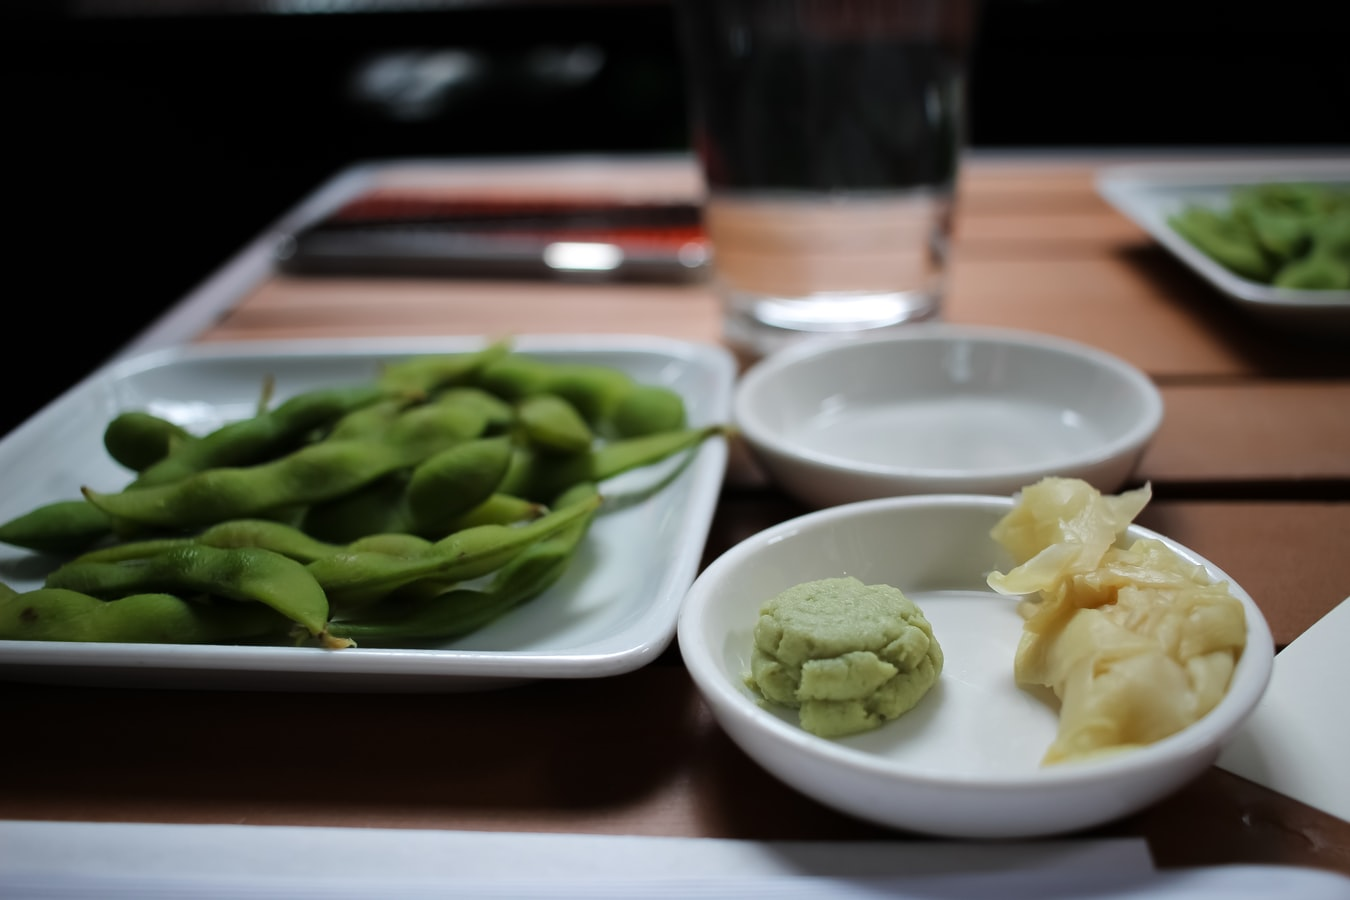

In [ ]:
#downloaded picture from unsplash
image_name3 = 'edamame_test.jpg'
Image(image_name3)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img3 = image.load_img(image_name3, target_size=(224, 224))
x = image.img_to_array(img3)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
pred = model.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[0.9704385  0.01516837 0.00580621 0.00683992 0.00174693]]
0


In [ ]:
result= np.argmax(pred)
if result==0:
    print("edamame")
elif result==1:
    print("ramen")
elif result==2:
    print("sushi")
elif result==3:
    print("sashimi")
elif result==4:
    print("miso soup")

edamame


### Predicting sashimi

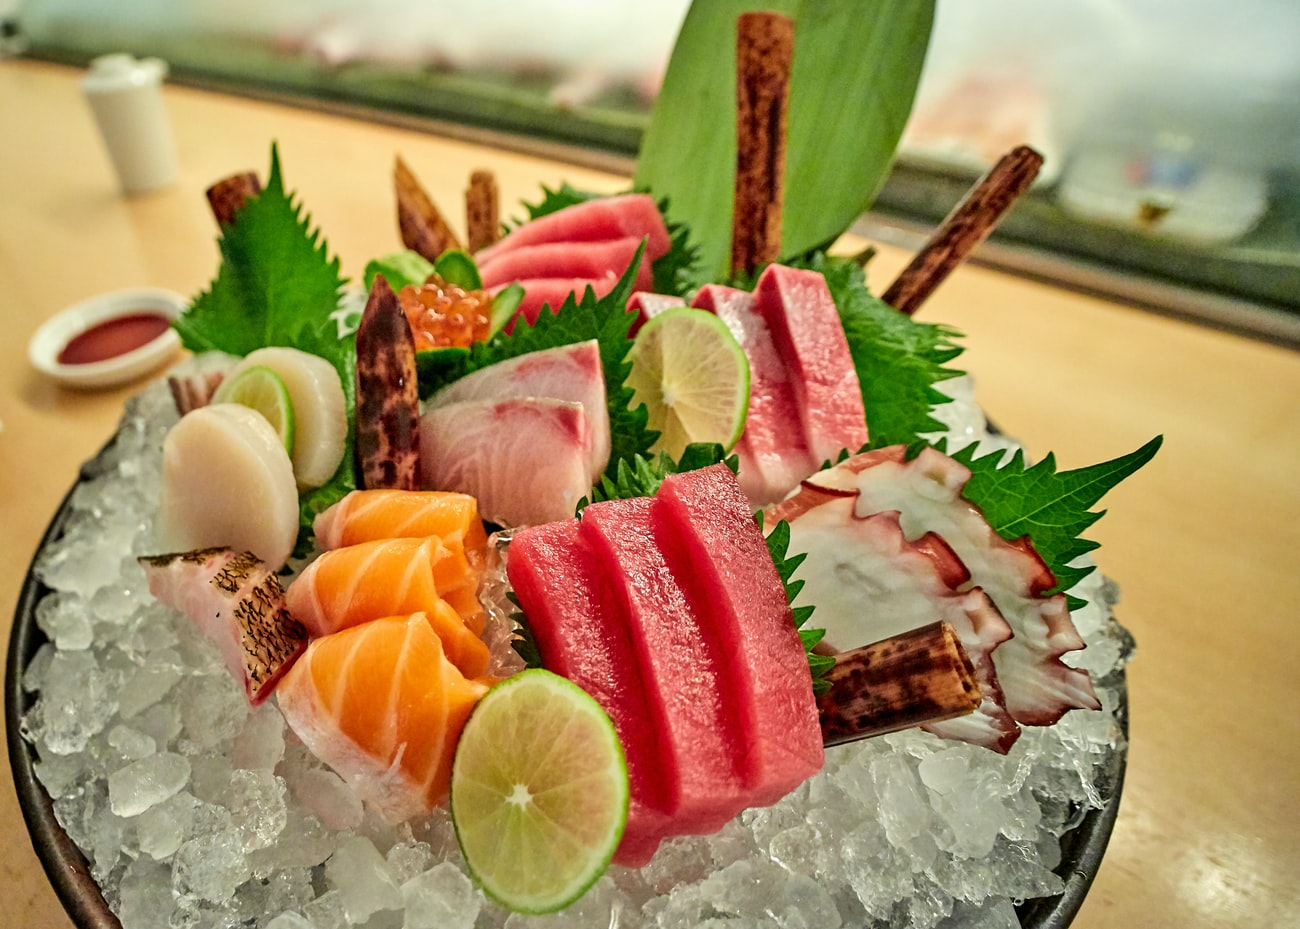

In [ ]:
#downloaded picture from unsplash
image_name4 = 'sashimi_test.jpg'
Image(image_name4)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img4 = image.load_img(image_name4, target_size=(224, 224))
x = image.img_to_array(img4)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
pred = model.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[1.4363643e-07 1.5531091e-06 7.6860845e-02 9.2313755e-01 1.1022513e-08]]
3


In [ ]:
result= np.argmax(pred)
if result==0:
    print("edamame")
elif result==1:
    print("ramen")
elif result==2:
    print("sushi")
elif result==3:
    print("sashimi")
elif result==4:
    print("miso soup")

sashimi


### Predicting miso soup

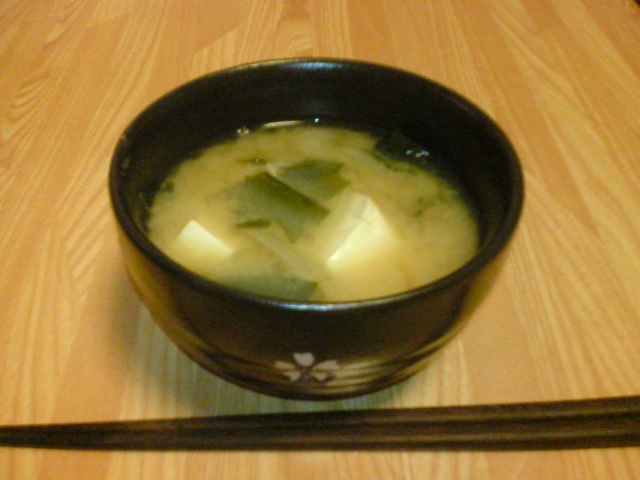

In [ ]:
#downloaded picture from unsplash
image_name5 = 'miso_test.jpg'
Image(image_name5)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img5 = image.load_img(image_name5, target_size=(224, 224))
x = image.img_to_array(img5)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
pred = model.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[3.1591252e-09 9.7527176e-05 3.6554604e-10 1.1014176e-06 9.9990141e-01]]
4


In [ ]:
result= np.argmax(pred)
if result==0:
    print("edamame")
elif result==1:
    print("ramen")
elif result==2:
    print("sushi")
elif result==3:
    print("sashimi")
elif result==4:
    print("miso soup")

miso soup


Our model takes the class with the highest probability as the prediction. np.argmax() returns the index with the highest value in an array, therefore we have used it for our predictions. 

We can also see from our base_cnn model (VGG16) that our model seems to be able to generalise well on unseen data, correctly predicting all 5 classes from images downloaded from the internet.

Our next step will be to begin our modelling process. We will select 10 categories with similar types of food (e.g. dessert/cakes), create our own Convolutional Neural Network and perform transfer learning with pretrained models before evaluating and selecting the best model.